### ML Assignment 4: Understanding the Impact of Ozempic on Obese and Hypertensive Patients
#### Group 12:
Leo, Rishi, Anurag

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import operator

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression
from math import sqrt
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read data
claims = pd.read_csv("longyear-obese-hypertensive-40-57-medical-SMALL-sample.csv")
prescription = pd.read_csv("longyear-obese-hypertensive-40-75-scripts-SMALL-sample.csv")

# remove any unnamed columns(if any)
claims = claims.loc[:, ~claims.columns.str.contains('^Unnamed')]
prescription = prescription.loc[:, ~prescription.columns.str.contains('^Unnamed')]

### 1. Exploratory Data Analysis
- Conduct a thorough exploration of the provided datasets. This includes understanding the structure, identifying missing values, and summarizing key statistics.
- Generate visualizations to understand the distribution of important variables, relationships between different variables, and any other patterns or anomalies in the data such as peculiar patterns or outliers.

In [3]:
## Filter Ozempic and Hypertension / Obesity from the datasets, more detail and explanation in part 2
# filtered out and keep prescription data that only uses Ozempic
ozem_ndc11 = ['00169413001','00169413013','00169413211','00169413212','00169413290','00169413297','00169413602','00169413611'
              ,'00169418103','00169418113','00169418190','00169418197','00169477211','00169477212','00169477290','00169477297'
             ,'5009051380','5009051390','5009060510','5009059490']

filtered_pres = prescription[prescription['ndc11'].isin(ozem_ndc11)]


# filtered out and keep E66 and I10 in diag_list for claims data
filtered_claims = claims[claims['diag_list'].str.contains('E66|I10', na=False)]

##### HeatMap

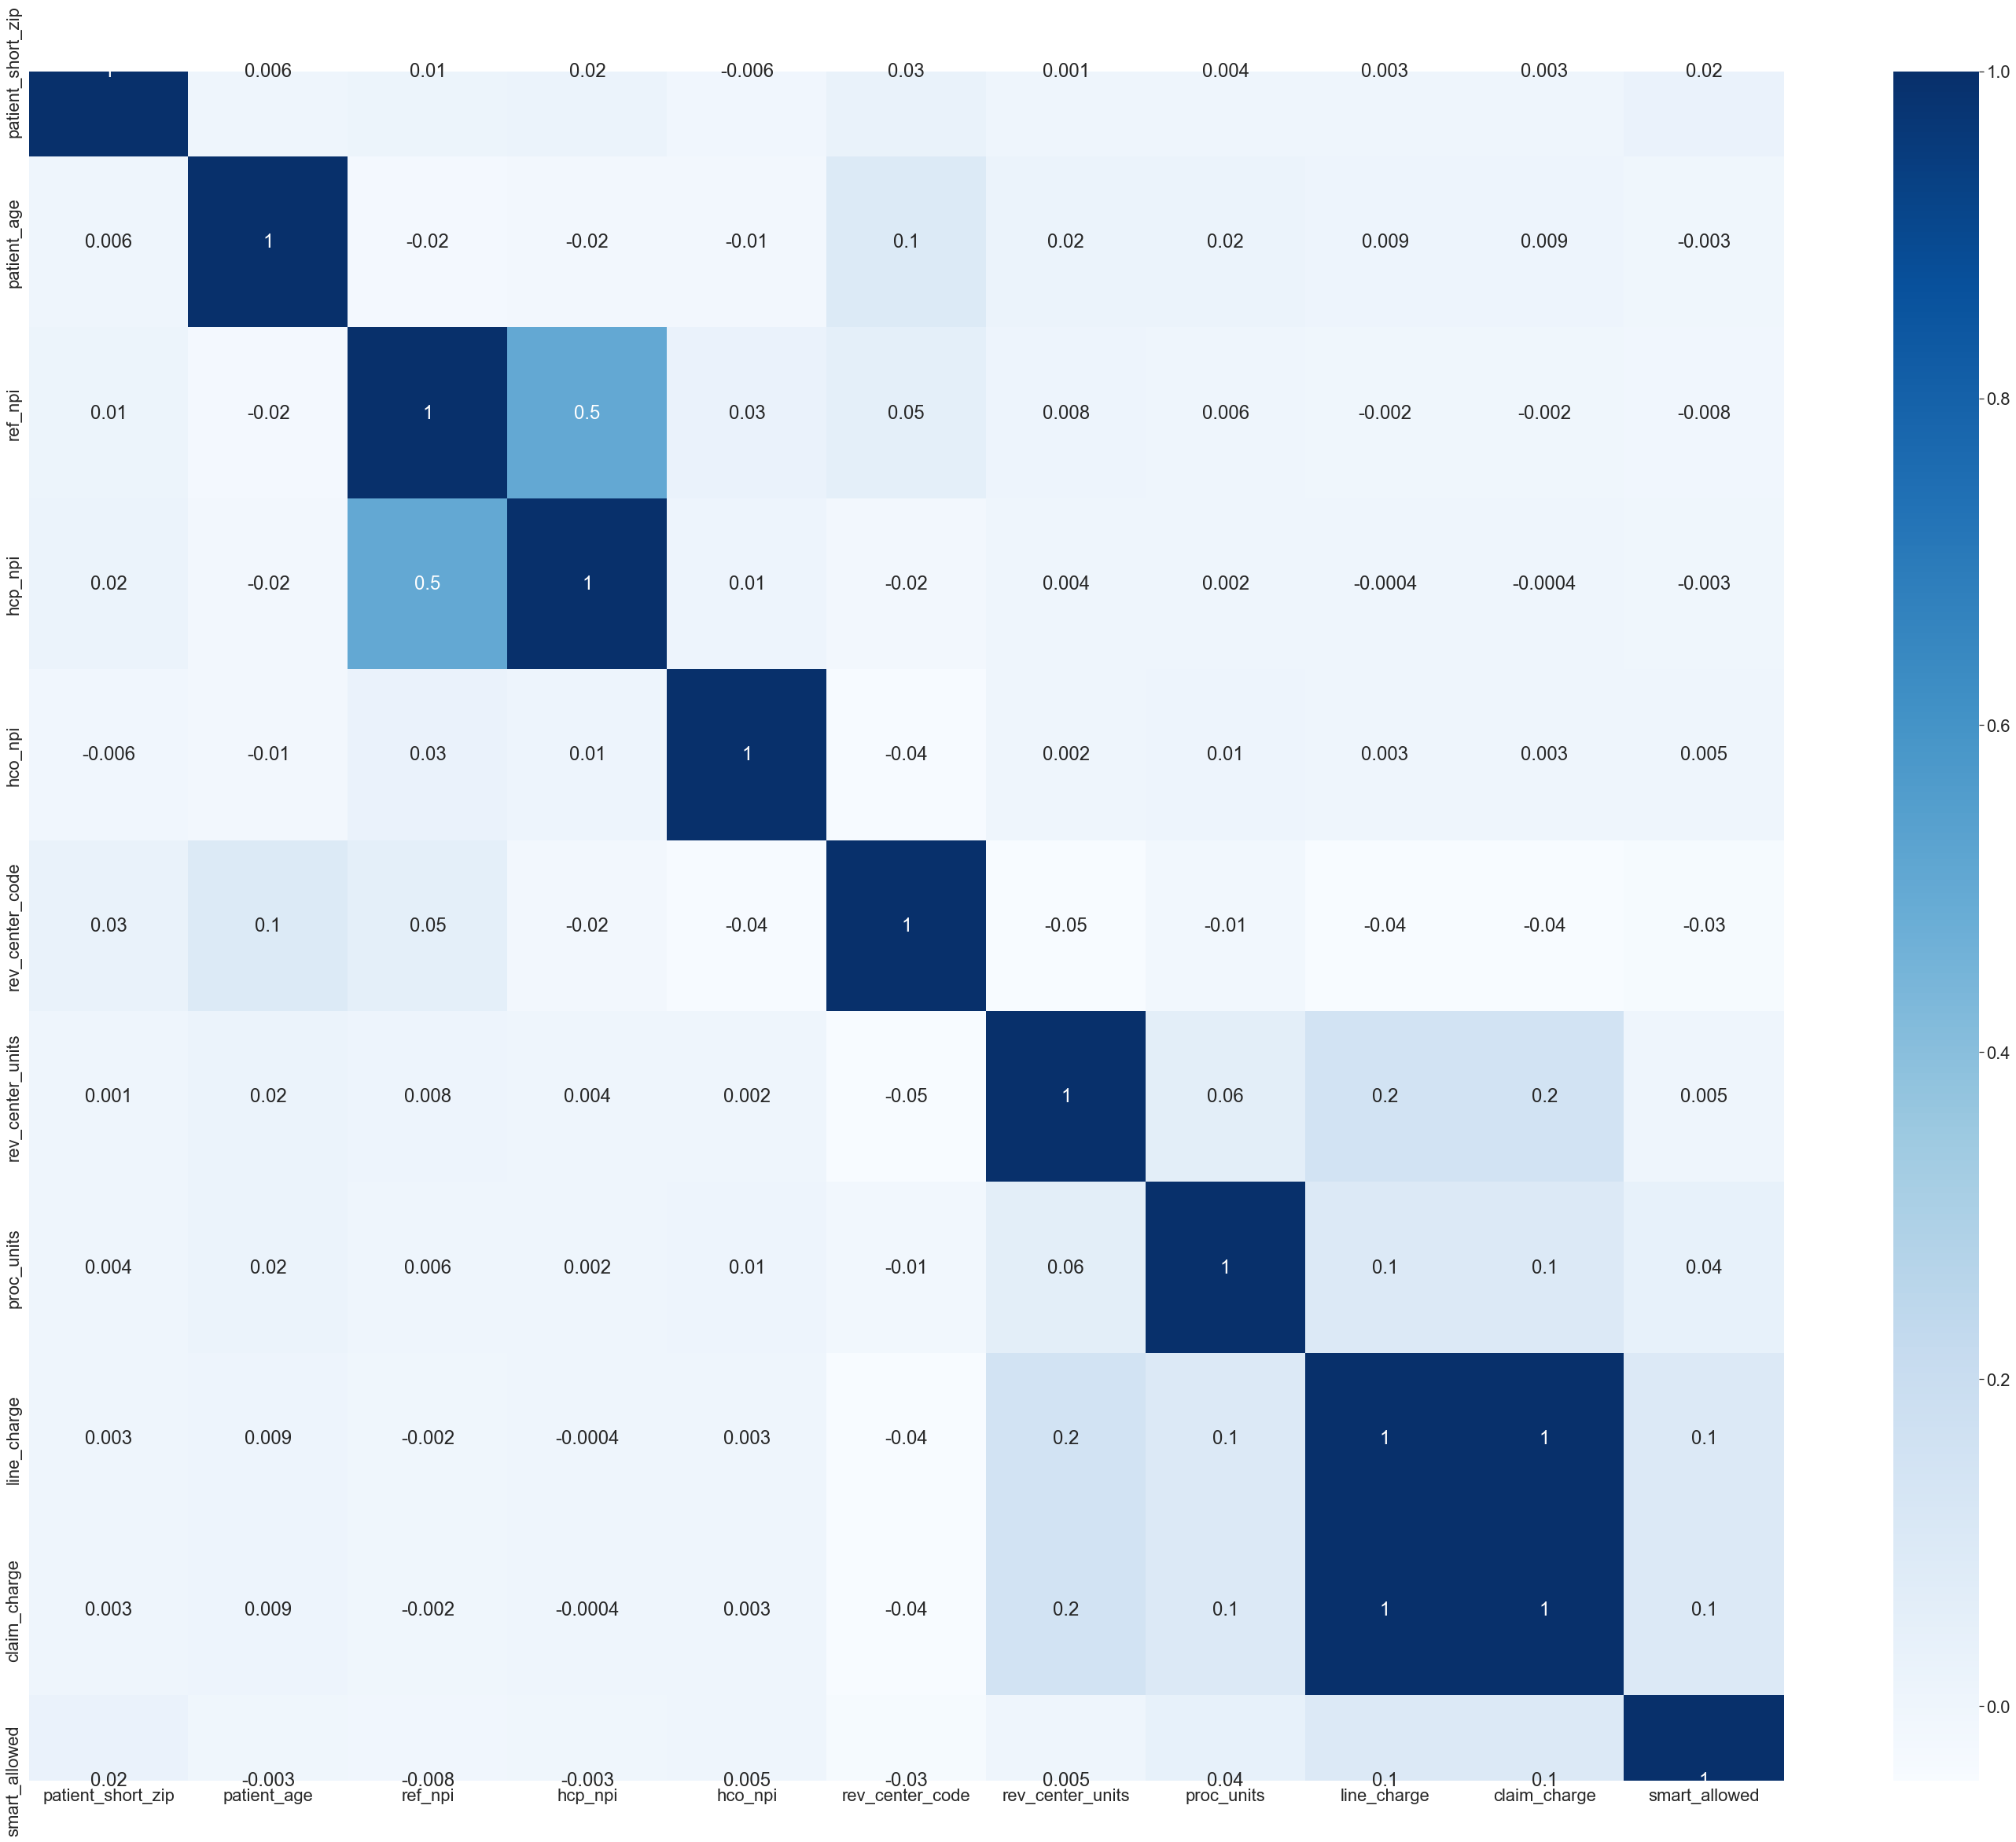

In [157]:
#Finding correlation of all the variables related to hypertension and obesity
plt.figure(figsize=(50,40))
sns.set(font_scale=2)
sns.heatmap(data=filtered_claims.corr(),annot=True,cmap='Blues',fmt='.1g')
plt.show()

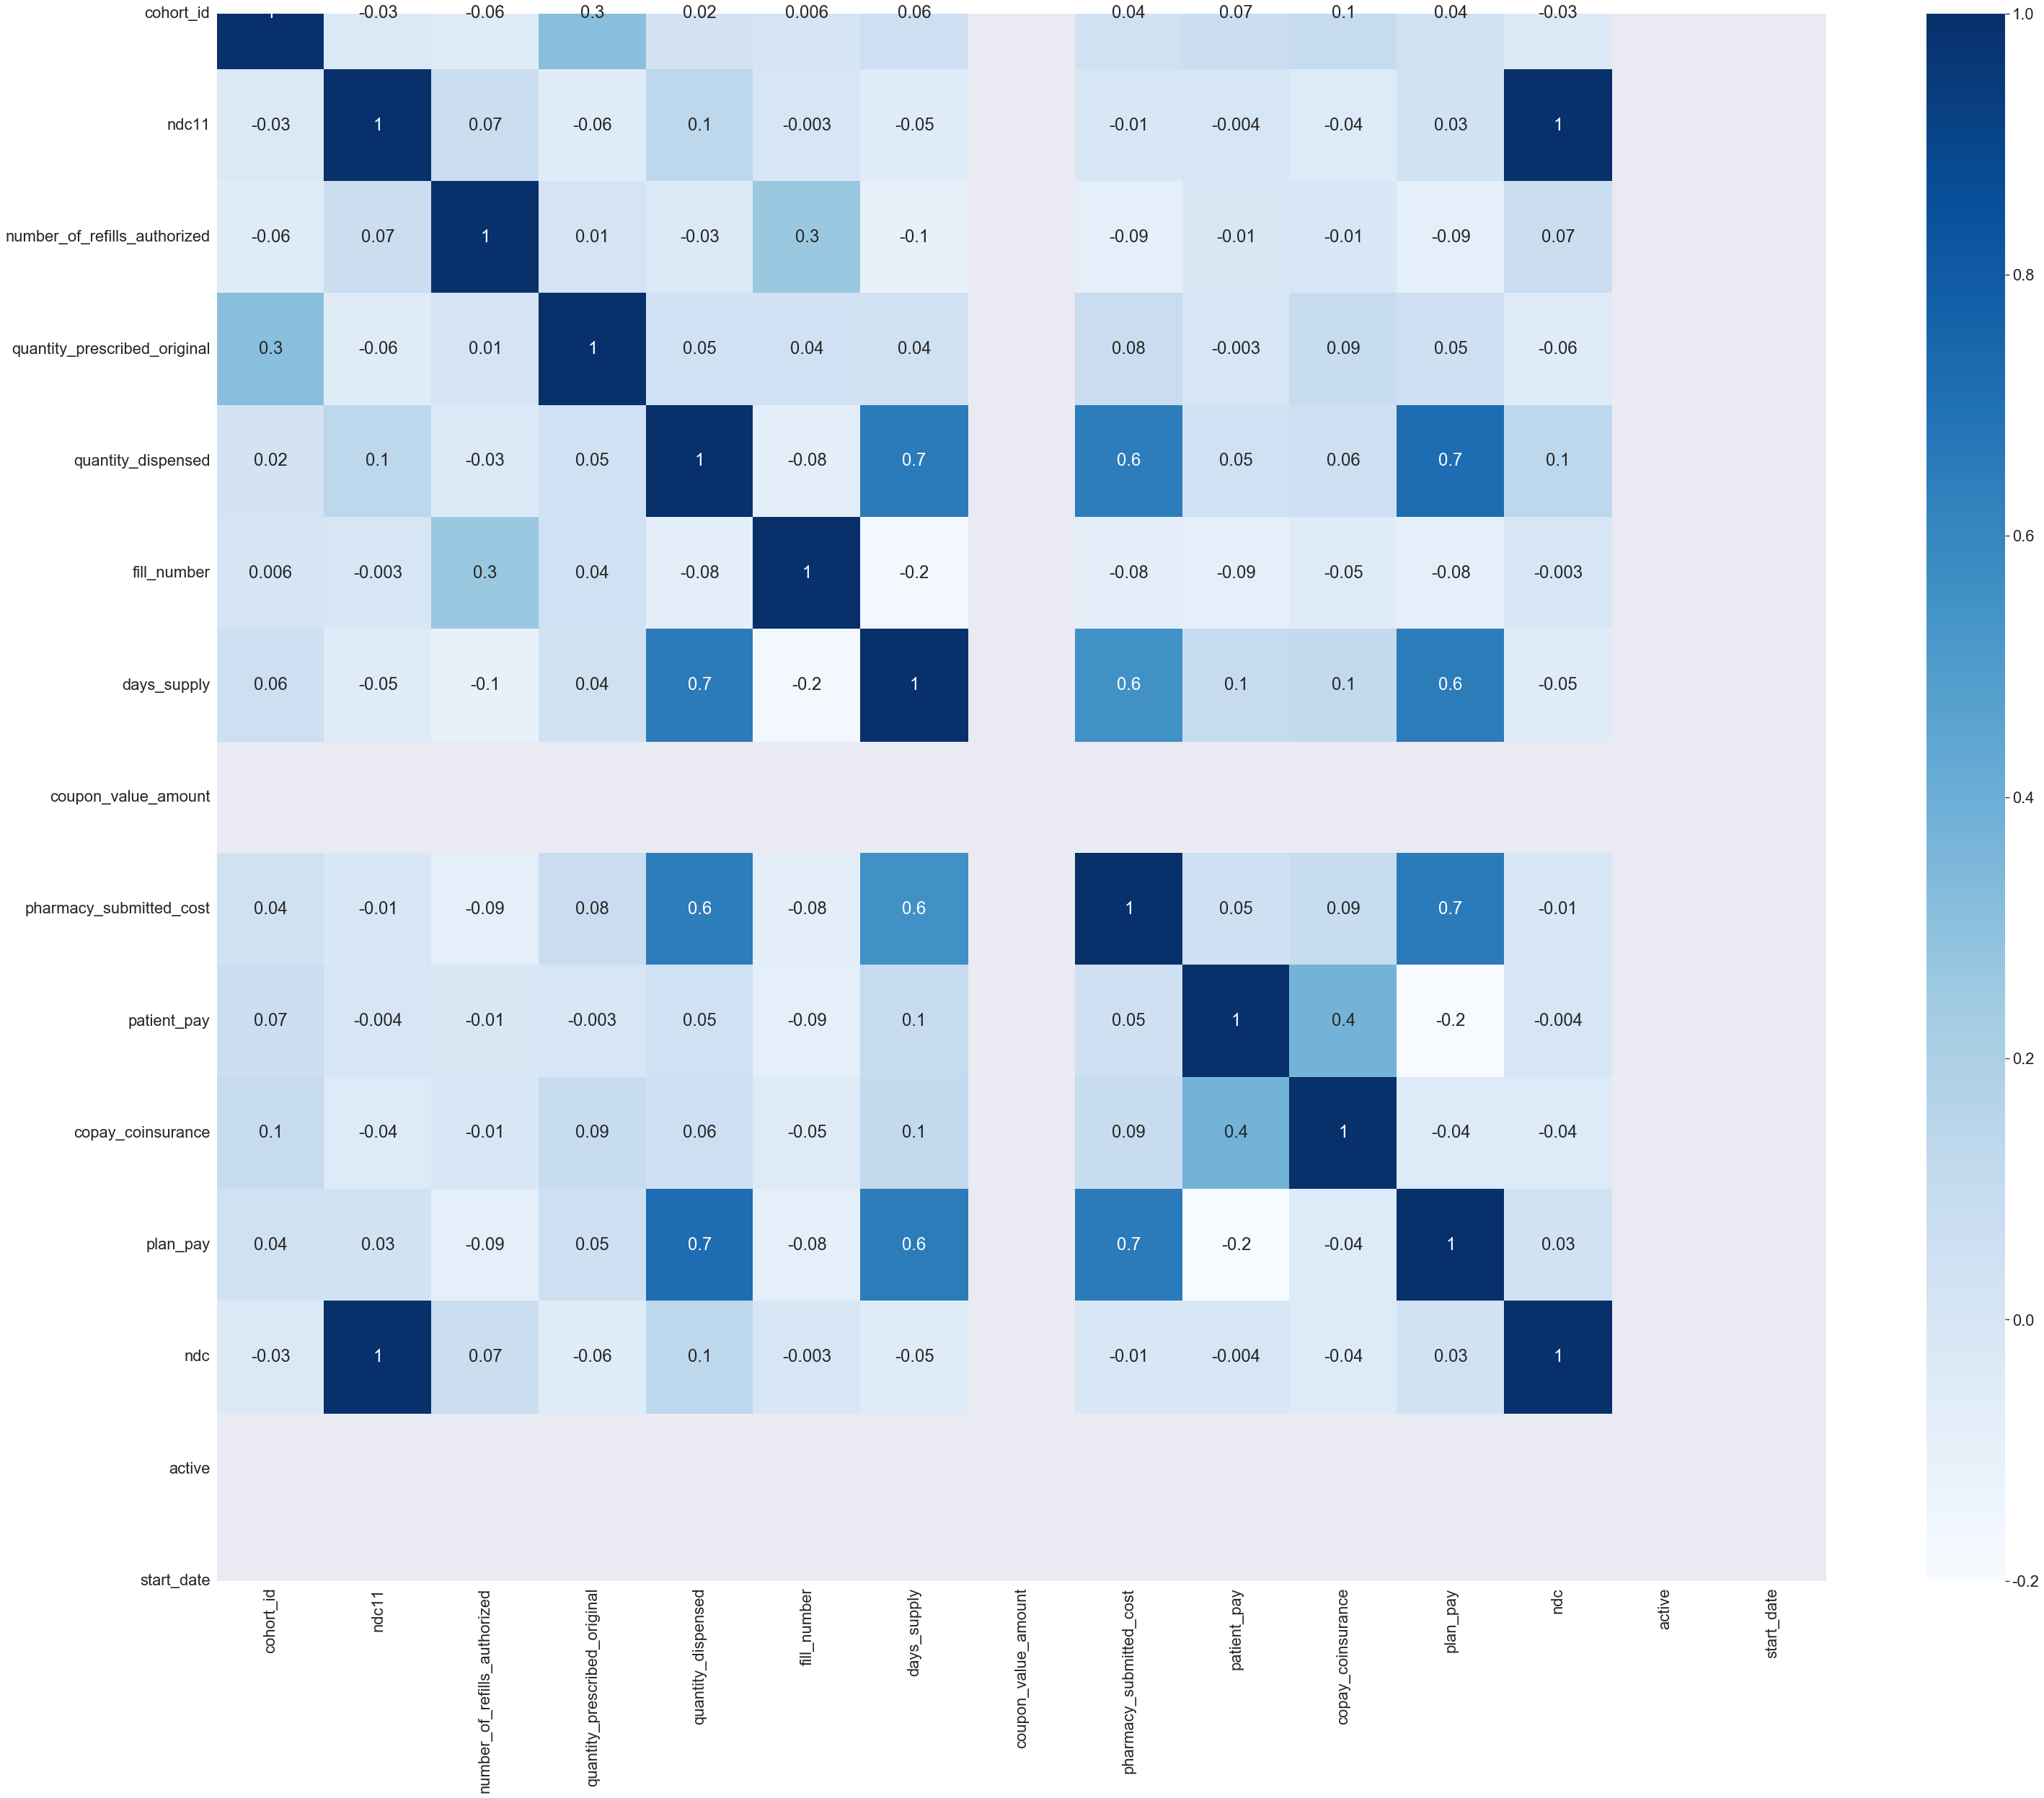

In [158]:
#Finding correlation of all the variables related to Ozempic
plt.figure(figsize=(50,40))
sns.set(font_scale=2)
sns.heatmap(data=filtered_pres.corr(),annot=True,cmap='Blues',fmt='.1g')
plt.show()

In [87]:
## Find the most common diagnosis
# select 'diag_' columns
diag_columns = [col for col in claims.columns if col.startswith('diag_')]
df_diag = claims[diag_columns]

# combine values 
combined_list = df_diag.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

first_three_diag = {}

for diag_code in combined_list:
    first_three = diag_code[:3]
    first_three_diag[first_three] = first_three_diag.get(first_three, 0) + 1


# Sort the dictionary items by count (descending order)
sorted_counts = sorted(first_three_diag.items(), key=operator.itemgetter(1), reverse=True)

sorted_counts

[('E11', 233629),
 ('I10', 199537),
 ('E78', 113939),
 ('Z00', 95083),
 ('E66', 69689),
 ('Z68', 54013),
 ('M25', 51750),
 ('M54', 50447),
 ('Z12', 32396),
 ('N18', 31950),
 ('Z01', 30622),
 ('Z13', 29844),
 ('M79', 29497),
 ('G47', 28339),
 ('R10', 27659),
 ('Z79', 27149),
 ('E55', 27085),
 ('Z71', 26523),
 ('R07', 25175),
 ('E03', 24910),
 ('R73', 24776),
 ('N39', 22340),
 ('M17', 21592),
 ('D64', 19973),
 ('I25', 17483),
 ('Z20', 16871),
 ('R53', 16402),
 ('I50', 15359),
 ('R06', 15340),
 ('J44', 14592),
 ('F41', 13833),
 ('Z23', 13598),
 ('I48', 12605),
 ('K21', 12366),
 ('G89', 11753),
 ('Z11', 11720),
 ('I11', 11344),
 ('F33', 10927),
 ('N40', 10720),
 ('J45', 10699),
 ('E87', 10668),
 ('M19', 10218),
 ('U07', 10043),
 ('M47', 9806),
 ('R68', 9479),
 ('A41', 9416),
 ('D50', 9387),
 ('J96', 9330),
 ('R05', 9106),
 ('M51', 8942),
 ('F32', 8895),
 ('I12', 8183),
 ('L03', 7899),
 ('B35', 7878),
 ('R79', 7617),
 ('Z51', 7527),
 ('R51', 7323),
 ('K76', 7175),
 ('Z76', 7142),
 ('R42', 7

Here, we can see that some of the most common diagnosis are:

- E11: Type 2 diabetes mellitus
- I10: Essential (primary) hypertension
- E78: Disorders of lipoprotein metabolism and other lipidemias
- Z00: Encounter for general examination without complaint, suspected or reported diagnosis
- E66: Overweight and obesity

In [159]:
# Know which zip code has the most patients with hypertension and obesity
df_zip = filtered_claims['patient_short_zip']

combined_list = df_zip.values.flatten().tolist()
combined_list = [x for x in combined_list if pd.notna(x)]

zips = {}

for diag_code in combined_list:
    zips[diag_code] = zips.get(diag_code, 0) + 1

    
sorted_counts = sorted(zips.items(), key=operator.itemgetter(1), reverse=True)

for items in sorted_counts:
    print(items)

(900.0, 163476)
(922.0, 157948)
(908.0, 51782)
(910.0, 45950)
(921.0, 44758)
(912.0, 31885)
(911.0, 29871)
(913.0, 26978)
(853.0, 5000)
(857.0, 2317)
(852.0, 1882)
(864.0, 1265)
(856.0, 1021)
(350.0, 980)
(859.0, 384)
(855.0, 376)
(351.0, 375)
(863.0, 366)
(352.0, 326)
(996.0, 298)
(995.0, 203)
(997.0, 193)
(860.0, 173)
(344.0, 58)
(850.0, 39)
(923.0, 25)
(891.0, 15)
(841.0, 12)
(170.0, 7)
(483.0, 7)
(787.0, 7)
(194.0, 7)
(334.0, 6)
(112.0, 4)
(337.0, 4)
(606.0, 3)
(895.0, 3)
(890.0, 3)
(933.0, 2)
(774.0, 2)
(74.0, 2)
(91.0, 2)
(999.0, 2)
(917.0, 2)
(442.0, 2)
(272.0, 2)
(109.0, 1)
(925.0, 1)
(495.0, 1)
(924.0, 1)
(928.0, 1)
(800.0, 1)
(612.0, 1)
(322.0, 1)
(101.0, 1)


From the table above, we can see that most services for hypertensive and obese patients were performed in zipcodes 900, 922, and 908

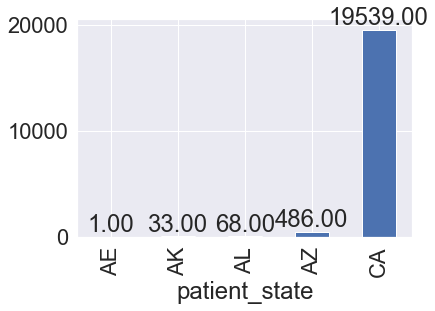

In [178]:
# Find the number of states for patients with hypertension and obesity
patient_state_cnt = filtered_claims.groupby('patient_state')['journey_id'].nunique()

# plot bar plot
patient_state_cnt.plot.bar()
for i, v in enumerate(patient_state_cnt):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

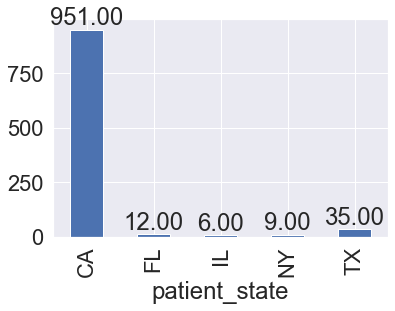

In [179]:
# Find the number of states for patients who used Ozempic
patient_state_cnt = filtered_pres.groupby('patient_state')['journey_id'].nunique()

# plot bar plot
patient_state_cnt.plot.bar()
for i, v in enumerate(patient_state_cnt):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

plt.show()

From the graphs above, we can see that most patients with hypertension and obesity are in California, and the majority of usage of Ozempic is also in California.

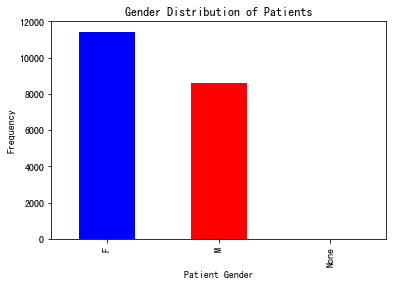

In [4]:
# Patient Gender Distribution for those with hypertension/obesity
gender = filtered_claims.groupby(['journey_id'])['patient_gender'].first().value_counts()
gender.plot(kind='bar', color=['blue', 'red'])

plt.xlabel('Patient Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution of Patients')

# Show the histogram
plt.show()

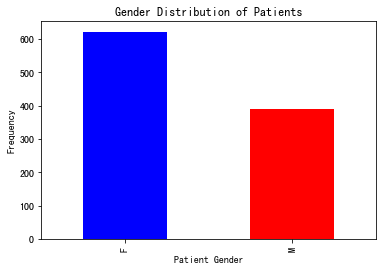

In [5]:
# Patient Gender Distribution for those who used Ozempic
gender = filtered_pres.groupby(['journey_id'])['patient_gender'].first().value_counts()
gender.plot(kind='bar', color=['blue', 'red'])

plt.xlabel('Patient Gender')
plt.ylabel('Frequency')
plt.title('Gender Distribution of Patients')

# Show the histogram
plt.show()

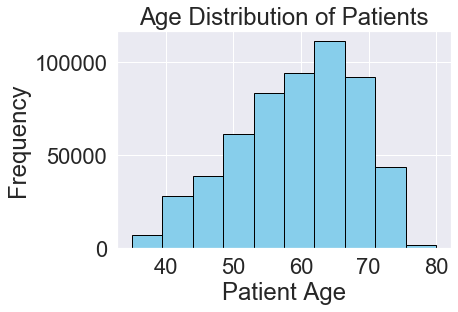

In [164]:
# Find age distribution of patients with hypertension and obesity
plt.hist(filtered_claims['patient_age'], bins=10, color='skyblue', edgecolor='black')

plt.xlabel('Patient Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Patients')

plt.show()

From the Age distribution graph above, we can see that most claims have patients with age around 65 years old, with the consistent increase in frequently starting from the age of around 30.

### 2. Data Preprocessing and Merging
- Prepare the datasets for analysis by handling missing data, encoding categorical variables, and any other necessary preprocessing steps.
- Merge the Medical and Prescription datasets appropriately, ensuring a coherent structure for further analysis.

After doing some research, we know that the Ozempic (semaglutide) does not have a unique CPT J code, instead, it shared the general codes C9399 and J3490 with other drugs. However, it does have a list of NDC11 codes:

#### Novo Nordisk packaged:

- 0169-4130-01, 0169-4130-13, 0169-4132-11, 0169-4132-12, 0169-4132-90, 0169-4132-97, 0169-4136-02, 0169-4136-11, 0169-4181-03, 0169-4181-13, 0169-4181-90, 0169-4181-97, 0169-4772-11, 0169-4772-12, 0169-4772-90, 0169-4772-97

#### A-S Medication Solutions Packaged:

- 50090-5138-0, 50090-5139-0, 50090-6051-0, 50090-5949-0


Since the dataset is focusing on the causal relationship of hypertension (I10) and obesity (E66) to the use of Ozempic, we just want to merge the data set with those data.

In [4]:
# filtered out and keep prescription data that only uses Ozempic
ozem_ndc11 = ['00169413001','00169413013','00169413211','00169413212','00169413290','00169413297','00169413602','00169413611'
              ,'00169418103','00169418113','00169418190','00169418197','00169477211','00169477212','00169477290','00169477297'
             ,'5009051380','5009051390','5009060510','5009059490']

filtered_pres = prescription[prescription['ndc11'].isin(ozem_ndc11)]


# filtered out and keep E66 and I10 in diag_list for claims data
filtered_claims = claims[claims['diag_list'].str.contains('E66|I10', na=False)]
all_id = filtered_claims['journey_id'].unique()

# return all rows where patient once diagnosed either hypertension and/or obesity
filtered_claims = claims[claims['journey_id'].isin(all_id)]

In [97]:
# merge the 2 dataframes
df_both = pd.merge(filtered_claims, filtered_pres, on='journey_id')
df_both.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260827 entries, 0 to 260826
Data columns (total 81 columns):
journey_id                       260827 non-null object
episode_id                       260827 non-null object
visit_id                         260389 non-null object
encounter_id                     260827 non-null object
claim_date                       260827 non-null object
patient_state_x                  260827 non-null object
patient_short_zip                260827 non-null float64
patient_age                      258247 non-null float64
patient_gender_x                 260827 non-null object
place_of_service_x               213521 non-null object
visit_type                       252595 non-null object
payor                            252940 non-null object
payor_channel                    244991 non-null object
ref_npi                          139714 non-null float64
hcp_npi                          168048 non-null float64
hcp_taxonomy                     165420 non-n

In [100]:
## Only keep columns we need
columns_to_keep = ['journey_id', 'claim_date', 'patient_gender_x', 'patient_state_x', 'patient_age',
                   'patient_zip', 'date_of_service', 'date_prescription_written',
                   'ndc11', 'diag_list']

# Remove columns not in the list
all_filtered = df_both.drop(columns=df_both.columns.difference(columns_to_keep))

In [101]:
all_filtered

,journey_id,claim_date,patient_state_x,patient_age,patient_gender_x,diag_list,patient_zip,date_of_service,date_prescription_written,ndc11
0,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,F,"M79641,M19041",922,2023-06-05,2023-06-05,169418113
1,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,F,"M79641,M19041",922,2023-06-05,2023-06-05,169418113
2,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,F,"M79641,M19041",922,2023-06-05,2023-06-05,169418113
3,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,F,"M79641,M19041",922,2023-06-05,2023-06-05,169418113
4,0003ff8dd03803a9197ed01075f4b094,2023-02-22,CA,60.0,F,"K3189,K2289",922,2023-06-05,2023-06-05,169418113
...,...,...,...,...,...,...,...,...,...,...
260822,1ff8ff0a9c69c0d70e83a2061727c792,2020-06-23,CA,50.0,F,"Z0000,E119",912,2023-01-04,2022-11-14,169413013
260823,1ff8ff0a9c69c0d70e83a2061727c792,2020-06-23,CA,50.0,F,"Z0000,E119",912,2023-04-17,2023-03-20,169413013
260824,1ff8ff0a9c69c0d70e83a2061727c792,2020-06-23,CA,50.0,F,"Z0000,E119",912,2023-05-18,2023-03-20,169413013
260825,1ff8ff0a9c69c0d70e83a2061727c792,2020-06-23,CA,50.0,F,"Z0000,E119",912,2023-03-20,2023-03-20,169413013


In [102]:
# Function to label 'I10' and 'E66' as 1 and non of the above as 0
def label_diagnosis(diag_list):
    if pd.notna(diag_list) and 'E66' in diag_list and 'I10' in diag_list:
        return 1
    elif pd.notna(diag_list) and 'E66' in diag_list:
        return 1
    elif pd.notna(diag_list) and 'I10' in diag_list:
        return 1
    else:
        return 0

all_filtered['diag_label'] = all_filtered['diag_list'].apply(label_diagnosis)

all_filtered['diag_label'].unique()

array([0, 1], dtype=int64)

In [103]:
# Add another column indicating if this row is before or after using Ozempic
# 0 = before, and 1 = after

# Function to determine the value based on the conditions
def compare_dates(row):
    if row['claim_date'] < row['date_prescription_written']:
        return 0
    elif row['claim_date'] > row['date_prescription_written']:
        return 1
    else:
        return 0

all_filtered['after_Ozempic'] = all_filtered.apply(compare_dates, axis=1)

Here, we created another column that indicates the diagnosis of a patient. We encode Hypertension (I10) to 1, Obesity (E66) to 2, and both diagnosis to 3. Also, if there is no these 2 types of diagnosis, we labeled it to 0.

Furthermore, we added another column that tells if the current claim is before or after getting prescribed an Ozmepic, indicating if the patient has already used Ozempic.

In [104]:
#Encode the gender to 0's and 1's
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the data
all_filtered['patient_gender_x'] = label_encoder.fit_transform(all_filtered['patient_gender_x'])

In [112]:
# fill age with average
all_filtered = all_filtered.fillna({'patient_age':all_filtered['patient_age'].mean()})

In [113]:
# find all patients that used Ozempic and has no more hypertension or obesity
id = all_filtered[(all_filtered['diag_label'] == 0) & (all_filtered['after_Ozempic'] == 1)]['journey_id'].unique()
hadOz = all_filtered[all_filtered['journey_id'].isin(id)]

In [114]:
hadOz.head()

,journey_id,claim_date,patient_state_x,patient_age,patient_gender_x,diag_list,patient_zip,date_of_service,date_prescription_written,ndc11,diag_label,after_Ozempic
0,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,0,"M79641,M19041",922,2023-06-05,2023-06-05,169418113,0,1
1,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,0,"M79641,M19041",922,2023-06-05,2023-06-05,169418113,0,1
2,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,0,"M79641,M19041",922,2023-06-05,2023-06-05,169418113,0,1
3,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,0,"M79641,M19041",922,2023-06-05,2023-06-05,169418113,0,1
4,0003ff8dd03803a9197ed01075f4b094,2023-02-22,CA,60.0,0,"K3189,K2289",922,2023-06-05,2023-06-05,169418113,0,0


In [115]:
print(hadOz.isnull().sum())

journey_id                   0
claim_date                   0
patient_state_x              0
patient_age                  0
patient_gender_x             0
diag_list                    0
patient_zip                  0
date_of_service              0
date_prescription_written    0
ndc11                        0
diag_label                   0
after_Ozempic                0
dtype: int64


In [116]:
# drop the na before analyzing
all_filtered.dropna(subset=['diag_list'], inplace=True)
hadOz.dropna(subset=['diag_list'], inplace=True)

In [117]:
hadOz

,journey_id,claim_date,patient_state_x,patient_age,patient_gender_x,diag_list,patient_zip,date_of_service,date_prescription_written,ndc11,diag_label,after_Ozempic
0,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,0,"M79641,M19041",922,2023-06-05,2023-06-05,169418113,0,1
1,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,0,"M79641,M19041",922,2023-06-05,2023-06-05,169418113,0,1
2,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,0,"M79641,M19041",922,2023-06-05,2023-06-05,169418113,0,1
3,0003ff8dd03803a9197ed01075f4b094,2023-07-17,CA,60.0,0,"M79641,M19041",922,2023-06-05,2023-06-05,169418113,0,1
4,0003ff8dd03803a9197ed01075f4b094,2023-02-22,CA,60.0,0,"K3189,K2289",922,2023-06-05,2023-06-05,169418113,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
260822,1ff8ff0a9c69c0d70e83a2061727c792,2020-06-23,CA,50.0,0,"Z0000,E119",912,2023-01-04,2022-11-14,169413013,0,0
260823,1ff8ff0a9c69c0d70e83a2061727c792,2020-06-23,CA,50.0,0,"Z0000,E119",912,2023-04-17,2023-03-20,169413013,0,0
260824,1ff8ff0a9c69c0d70e83a2061727c792,2020-06-23,CA,50.0,0,"Z0000,E119",912,2023-05-18,2023-03-20,169413013,0,0
260825,1ff8ff0a9c69c0d70e83a2061727c792,2020-06-23,CA,50.0,0,"Z0000,E119",912,2023-03-20,2023-03-20,169413013,0,0


### Question 3: Causal Analysis Setup
- Discuss the potential endogeneity issues in estimating the treatment effect of Ozempic on the target population.
- Outline your strategy for addressing endogeneity, referencing the big-picture problem of causality and treatment effect estimation discussed in class.

### Question 4: Model Development: Double-Lasso / Treatment Effect Lasso
- Implement the double-lasso technique to estimate the treatment effect of Ozempic, considering the endogeneity of treatment assignment.
- Justify the inclusion of variables in your model, explaining the rationale behind each decision.

In [124]:
#Partial Lasso Class referred from Jacob 
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss

class SelectiveRegularizationLogisticRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, penalty_indices, penalty_weights, tol=1e-4, max_iter=100):
        self.penalty_indices = penalty_indices
        self.penalty_weights = penalty_weights
        self.tol = tol
        self.max_iter = max_iter
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _predictions(self, coef, X):
        predictions = self._sigmoid(X @ coef)
        return predictions
        
    def _loss(self, coef, X, y):
        predictions = self._sigmoid(X @ coef)
        # Basic log loss
        basic_loss = log_loss(y, predictions)
        
        # Regularization term, selectively applied with L1 penalty
        reg_term = sum(self.penalty_weights[i] * abs(coef[self.penalty_indices[i]]) for i in range(len(self.penalty_indices)))
        
        return basic_loss + reg_term
    
    def fit(self, X, y):
        # Add intercept term
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        
        initial_coef = np.zeros(X.shape[1])
        result = minimize(self._loss, initial_coef, args=(X, y), method='SLSQP', tol=self.tol, options={'maxiter': self.max_iter})
        
        self.coef_ = result.x
        return self
    
    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        proba = self._sigmoid(X @ self.coef_)
        return np.vstack([1-proba, proba]).T
    
    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

In [121]:
first_lasso = hadOz.drop(['journey_id','claim_date', 'patient_state_x', 'diag_list','patient_zip', 'date_of_service', 'date_prescription_written', 'ndc11'], axis=1)

In [122]:
first_lasso

,patient_age,patient_gender_x,diag_label,after_Ozempic
0,60.0,0,0,1
1,60.0,0,0,1
2,60.0,0,0,1
3,60.0,0,0,1
4,60.0,0,0,0
...,...,...,...,...
260822,50.0,0,0,0
260823,50.0,0,0,0
260824,50.0,0,0,0
260825,50.0,0,0,0


In [125]:
#Let us ignore run time warnings
from scipy.optimize import minimize

warnings.filterwarnings("ignore", category=RuntimeWarning)

X = first_lasso.drop(['diag_label'], axis=1).values
y = first_lasso['diag_label'].values

#Creating the lambda test values, as we have only few variables, we'll choose a smaller range for lambda testing
lambda_values= np.logspace(-2, 0, 30)

#Creating the train, test split for our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

best_lambda = None
lowest_loss = float('inf') #Setting the highest value for first conditional reference

penalty_indices = [0,1,2]  # Apply penalties to all coefficients

#Run over different lambda values
for lambda_val in lambda_values:
    penalty_weights = [lambda_val] * len(penalty_indices)
    
    model = SelectiveRegularizationLogisticRegression(penalty_indices=penalty_indices, penalty_weights=penalty_weights)
    model.fit(X_train, y_train)
    
    current_loss = model._loss(model.coef_[1:4], X_test, y_test)

    #If loss is the lowest, that lamda will be best lambda 
    if current_loss < lowest_loss:
        best_lambda = lambda_val
        lowest_loss = current_loss

print("Best Lambda:", best_lambda)
print("Lowest Loss:", lowest_loss)

Best Lambda: 0.01
Lowest Loss: 0.6492917444356815


In [126]:
penalty_indices = [0, 1,2]  # Apply penalties to all coefficients
penalty_weights = [0.01]*3  # Penalty weights for these coefficients

model_1 = SelectiveRegularizationLogisticRegression(penalty_indices=penalty_indices, penalty_weights=penalty_weights)
model_1.fit(X, y)


#Predicting treatment on other confounding variables 
predictions = model_1._predictions(model.coef_[1:4],X)

In [127]:
hadOz['treatment_hat']=predictions

In [131]:
second_lasso = hadOz.drop(['journey_id','claim_date', 'patient_state_x', 'diag_list','patient_zip', 'date_of_service', 'date_prescription_written', 'ndc11'], axis=1).copy()

In [132]:
second_lasso

,patient_age,patient_gender_x,diag_label,after_Ozempic,treatment_hat
0,60.0,0,0,1,0.305710
1,60.0,0,0,1,0.305710
2,60.0,0,0,1,0.305710
3,60.0,0,0,1,0.305710
4,60.0,0,0,0,0.305725
...,...,...,...,...,...
260822,50.0,0,0,0,0.335484
260823,50.0,0,0,0,0.335484
260824,50.0,0,0,0,0.335484
260825,50.0,0,0,0,0.335484


In [133]:
#Let us ignore run time warnings, as it is a lot 
warnings.filterwarnings("ignore", category=RuntimeWarning)

X = second_lasso.drop(['after_Ozempic'], axis=1).values
y = second_lasso['after_Ozempic'].values

#Creating the lambda test values, as we have only few variables, we'll choose a smaller range for lambda testing
lambda_values= np.logspace(-2, 0, 30)

#Creating the train, test split for our data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

best_lambda = None
lowest_loss = float('inf') #Setting the highest value for first conditional reference

penalty_indices = [0, 1,2,3]  # Apply penalties to all coefficients except the last one (treatment_hat)

#Run over different lambda values
for lambda_val in lambda_values:
    penalty_weights = [lambda_val] * len(penalty_indices)
    
    model = SelectiveRegularizationLogisticRegression(penalty_indices=penalty_indices, penalty_weights=penalty_weights)
    model.fit(X_train, y_train)
    
    current_loss = model._loss(model.coef_[1:6], X_test, y_test)

    #If loss is the lowest, that lamda will be best lambda 
    if current_loss < lowest_loss:
        best_lambda = lambda_val
        lowest_loss = current_loss

print("Best Lambda:", best_lambda)
print("Lowest Loss:", lowest_loss)

Best Lambda: 0.01
Lowest Loss: 0.5874076112574115


In [134]:
X = second_lasso.drop(['after_Ozempic'], axis=1).values
y = second_lasso['after_Ozempic'].values

penalty_indices = [0, 1,2,3]  # Apply penalties to all coefficients
penalty_weights = [0.01]*4  # Penalty weights for these coefficients

model_2 = SelectiveRegularizationLogisticRegression(penalty_indices=penalty_indices, penalty_weights=penalty_weights)
model_2.fit(X, y)


model_2.coef_

array([-0.01180335, -0.01607564,  0.00424534, -0.00804137, -0.01631115])

In [136]:
#find treatment effect
{round(model_2.coef_[4],3)}

{-0.016}

We did 2 lassos: first on whether a patient has obesity/hypertension and second on whether the patient has taken Ozempic
The treatment effect I got here is negative and very close to 0. Either there are no true effect or there are error in the calculation.

### Question 5: Model Evaluation and Interpretation
- Evaluate the performance of your model, discussing the implications of your findings.
- Interpret the estimated treatment effects, providing insights into the impact of Ozempic on the target patient population.

In [137]:
model_2._loss(model_2.coef_[1:6], X, y)

0.587540668028248

### Question 6: Additional Insights
- Utilize the census and additional Ozempic information to enrich your analysis. This could involve integrating demographic factors from selected zip code prefixes to explore how they might influence treatment effects or reveal interesting patterns related to the use of Ozempic.
- If you prefer, you can incorporate these additional insights into your EDA section. Whether included in the EDA or as a separate section, the allocation of points will not be affected.
- Flexibility in Approach: This assignment is designed to encourage creative and critical thinking. You are free to explore the datasets from various angles and use any methods, functions, or packages you find appropriate for your analysis. The emphasis is on the quality of insights generated and the justification of your analytical choices, rather than adherence to a prescribed set of tools or techniques.